In [1]:
from torch import nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import sys
import platform
from IPython.display import clear_output
from tqdm.notebook import tqdm
from time import sleep
import numpy as np

In [2]:
# What version of Python do you have?

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps:0" if getattr(torch,'has_mps',False) \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.4.1-arm64-arm-64bit
PyTorch Version: 2.1.0.dev20230416

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps:0


### Load MNIST

In [4]:
EPOCHS = 50
batch_size = 32


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])



trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

dataiter = iter(testloader)
images, labels = next(dataiter)
random_image = images[0]


# display(T.ToPILImage()(inverse_transform(random_image).squeeze(0)).resize((200, 200)))

undo_transform = T.Normalize(mean=-1.0, std=2.0)

In [5]:
labels.shape

torch.Size([32])

In [10]:
class G_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(100 + 10, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, X, labels):
        emb = self.embed(labels)
        return self.model(torch.cat((X, emb), dim=1)).view(-1, 28, 28)

class D_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(784 + 10, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 28 * 28),
            nn.LeakyReLU(0.2),
            nn.Linear(28 * 28, 1),
            nn.LeakyReLU(0.2),
        )


    def forward(self, X, labels):
        emb = self.embed(labels)
        X_ = X.view(batch_size, -1)
        return self.model(torch.cat((X_, emb), dim=1))

class GAN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        # terrible thing with device, mb this this
        self.G = G_model().to(device)
        self.D = D_model().to(device)

    def forward(self, n, labels=None):
        if labels is None:
            labels = torch.randint(0, 10, (n,)).to(self.device)
        labels = labels.to(self.device)
        noise = torch.randn((n, 100), device=self.device)
        return self.G(noise, labels)

    def train_(self, dataloader, EPOCHS=100, verbose=True):
        num_imgs = 10
        noise_fixed = torch.randn((num_imgs, 100), device=self.device)
        labels_fixed = torch.arange(10).to(self.device)

        criterion = nn.BCEWithLogitsLoss()

        optimizer_G = torch.optim.Adam(
            self.G.parameters(), lr=3e-4)
        optimizer_D = torch.optim.Adam(
            self.D.parameters(), lr=3e-4)


        batch_size = dataloader.batch_size
        G_loss_lst, D_loss_lst = [], []

        for epoch in tqdm(range(EPOCHS), desc="Epoch"):
            G_running_loss_lst = []
            D_running_loss_lst = []
            for i, (X, labels) in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch}")):
                # Label Smoothing,
                # i.e. if you have two target labels:
                # Real=1 and Fake=0, then for each incoming sample, if it is real,
                # then replace the label with a random number between 0.7 and 1.2,
                # and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
                # Salimans et. al. 2016
                # ones = (0.7 - 1.2) * torch.rand(batch_size,
                                                # device=self.device) + 1.2
                # zeros = 0.3 * torch.rand(batch_size, device=self.device)


                ones = torch.ones(batch_size, device=self.device)
                zeros = torch.zeros(batch_size, device=self.device)

                noise = torch.randn((batch_size, 100), device=self.device)
                labels = labels.to(self.device)

                # iteration for discriminator
                z = self.G(noise, labels)

                pred_fake = self.D(z.detach(), labels).squeeze(-1)
                pred_real = self.D(X.to(self.device), labels).squeeze(-1)

                D_loss = criterion(pred_fake, zeros) + \
                    criterion(pred_real, ones)

                D_loss.backward()
                optimizer_D.step()
                D_running_loss_lst.append(D_loss.item())

                # iteration for the generator
                pred = self.D(z, labels).squeeze(-1)
                G_loss = criterion(pred, ones)

                G_loss.backward()
                optimizer_G.step()
                G_running_loss_lst.append(G_loss.item())

                optimizer_D.zero_grad()
                optimizer_G.zero_grad()


                # fix noise + logging
                if (i + 1) % 500 == 0:
                    self.eval()
                    with torch.no_grad():
                        # Adjust the figsize as per your preference
                        _, axs = plt.subplots(1, num_imgs, figsize=(17, 6))

                        # imgs = self.G(noise_fixed)
                        imgs = self.G(noise_fixed, labels_fixed)
                        for j, img in enumerate(imgs):
                            axs[j].imshow(
                                undo_transform(img.cpu().detach().view(1, 28, 28)).view(28, 28).numpy(), cmap="gray")

                        plt.show()
                        self.train()

                        print("G_loss:", np.mean(G_running_loss_lst), "D_loss:", np.mean(D_running_loss_lst))
                        plt.plot(torch.tensor(G_running_loss_lst).view(-1, 10).mean(1), label='G-loss')
                        plt.plot(torch.tensor(D_running_loss_lst).view(-1, 10).mean(1), label='D-loss')
                        plt.legend(loc='upper right')
                        plt.show()

            G_loss_lst.append(np.mean(G_running_loss_lst))
            D_loss_lst.append(np.mean(D_running_loss_lst))

            print("G_loss:", np.mean(G_running_loss_lst), "D_loss:", np.mean(D_running_loss_lst))
            plt.plot(G_running_loss_lst, label='G-loss')
            plt.plot(D_running_loss_lst, label='D-loss')
            plt.legend(loc='upper right')
            plt.show()

        return G_loss_lst, D_loss_lst


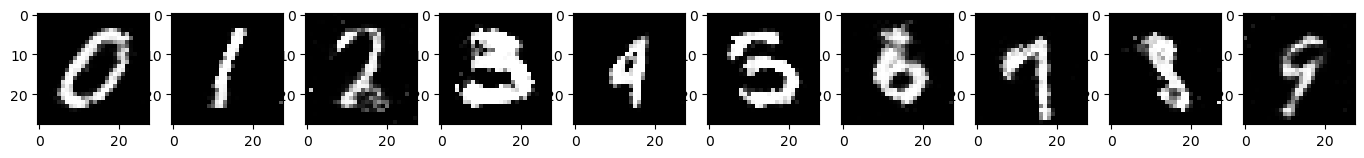

G_loss: 1.0410040279229482 D_loss: 1.185746806383133


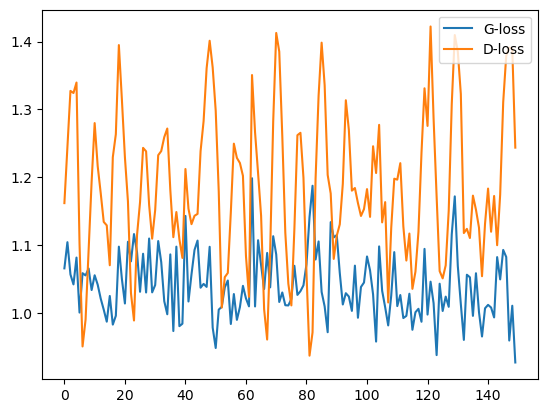

G_loss: 1.0380920385996502 D_loss: 1.1837883705774943


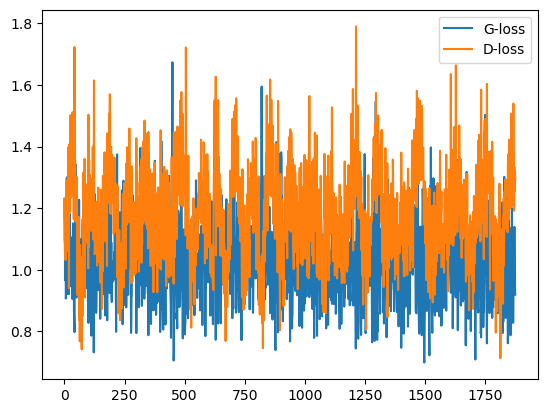

Epoch 47:   0%|          | 0/1875 [00:00<?, ?it/s]

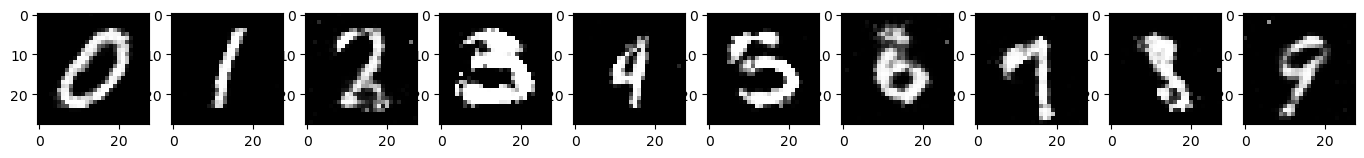

G_loss: 1.0013442808389663 D_loss: 1.1569271500110627


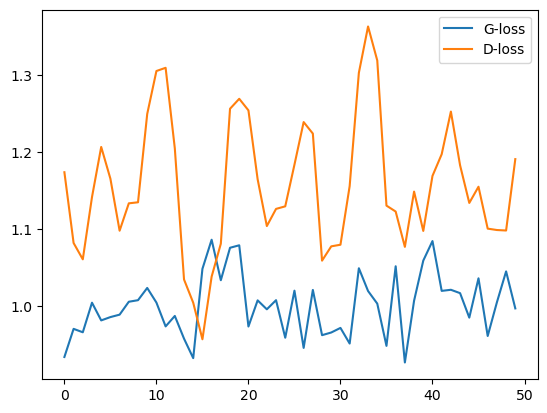

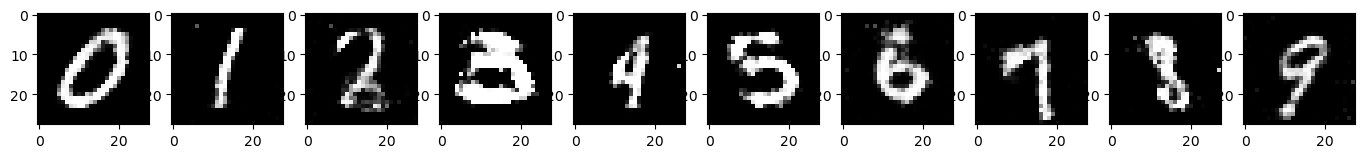

G_loss: 1.000405225455761 D_loss: 1.174177572131157


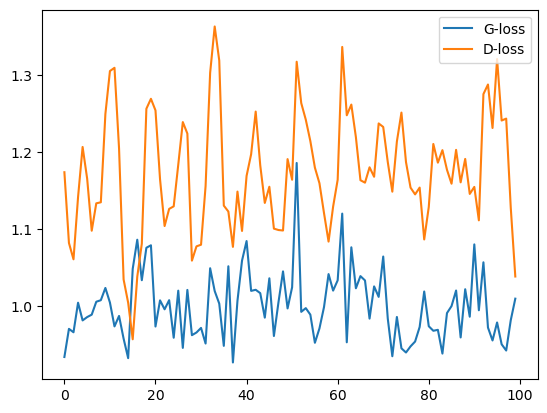

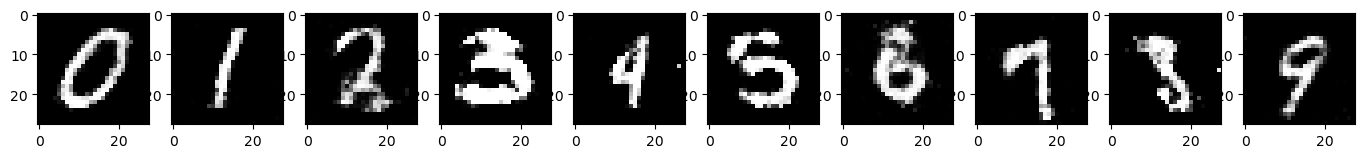

G_loss: 1.0006661551793417 D_loss: 1.1751213478644689


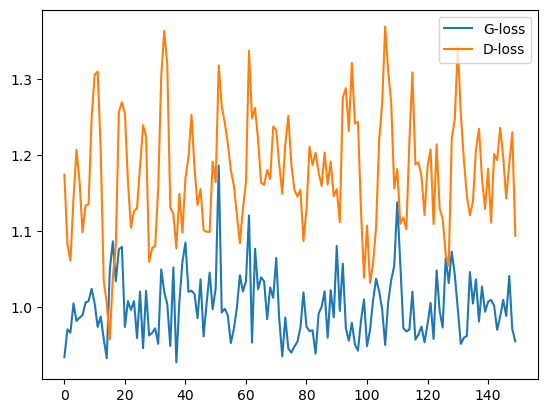

G_loss: 1.0043762131690979 D_loss: 1.1779027943929037


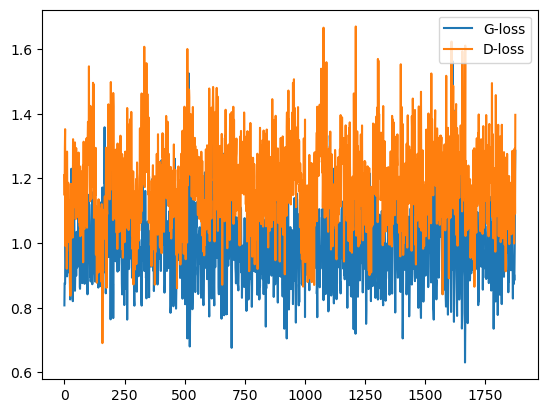

Epoch 48:   0%|          | 0/1875 [00:00<?, ?it/s]

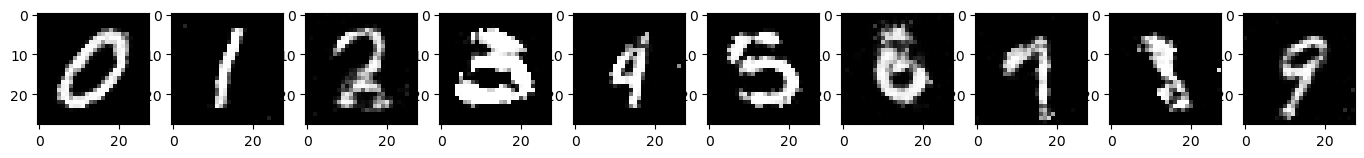

G_loss: 1.0044522622823715 D_loss: 1.192607738137245


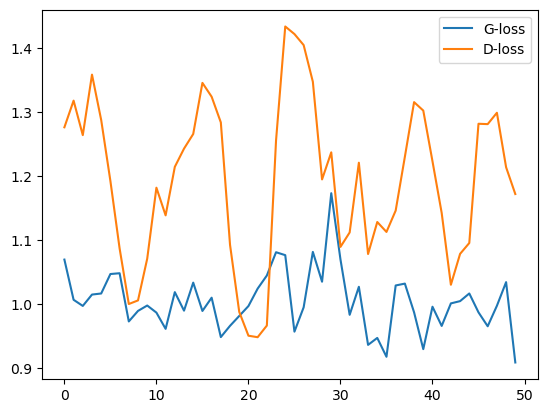

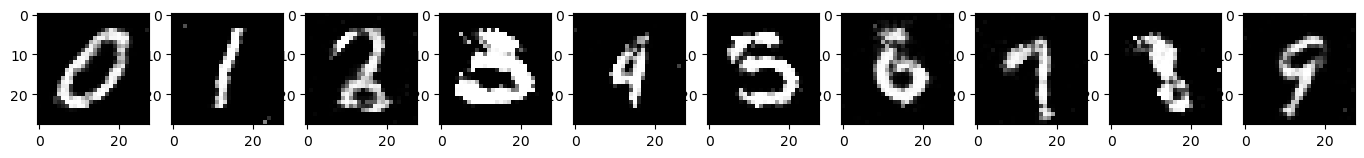

G_loss: 1.0118549209833145 D_loss: 1.189987156033516


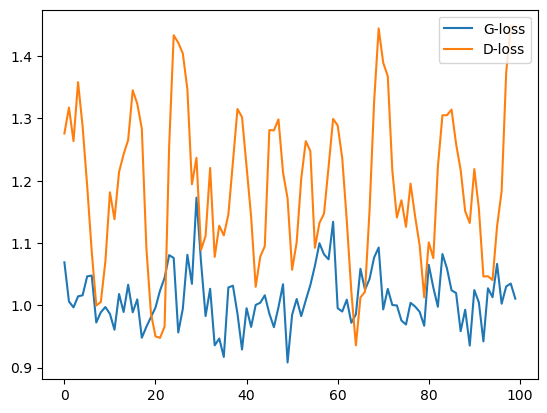

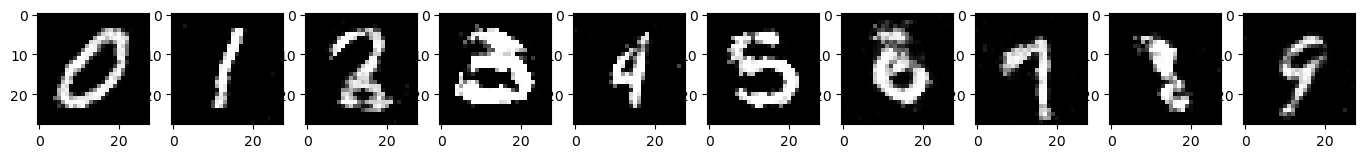

G_loss: 1.0169175715049108 D_loss: 1.186059379418691


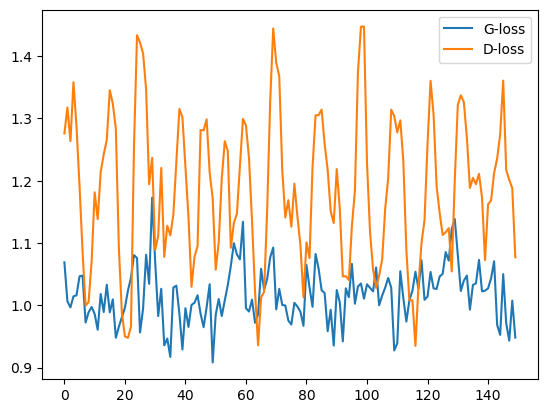

G_loss: 1.0159409107844035 D_loss: 1.1858153588612874


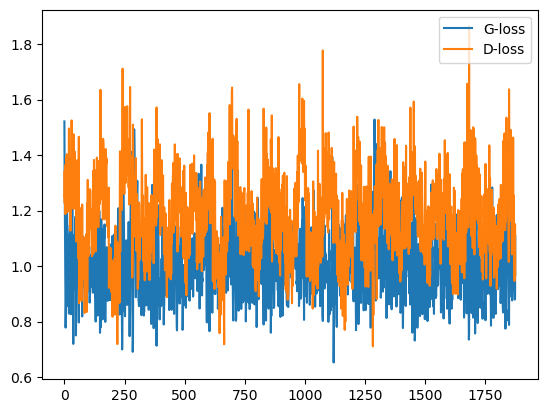

Epoch 49:   0%|          | 0/1875 [00:00<?, ?it/s]

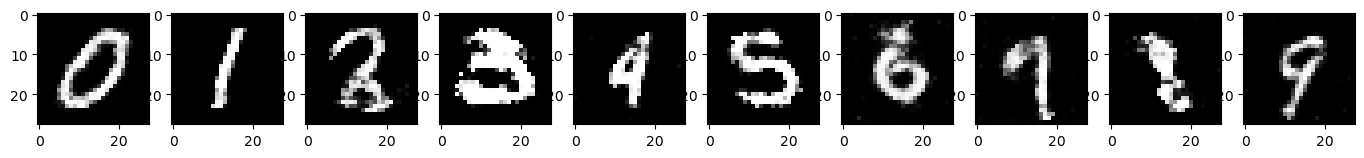

G_loss: 1.014378779053688 D_loss: 1.176521756529808


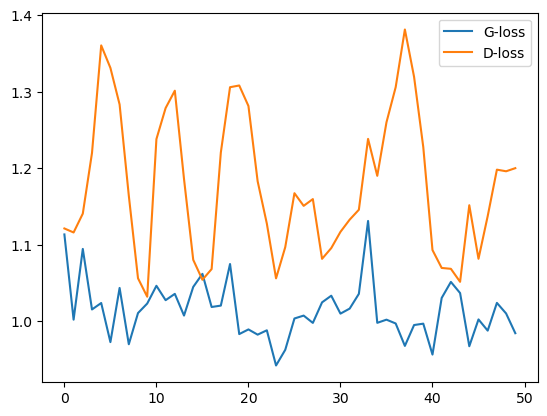

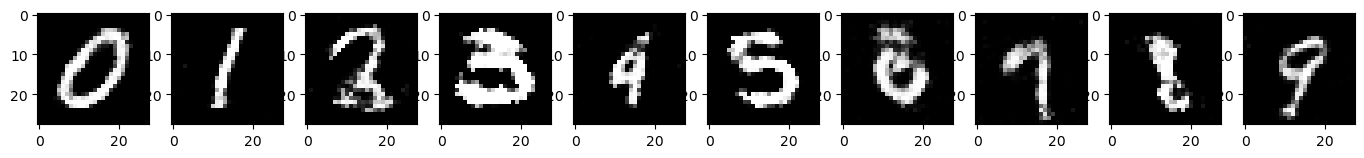

G_loss: 1.0099902550578117 D_loss: 1.1848903902173042


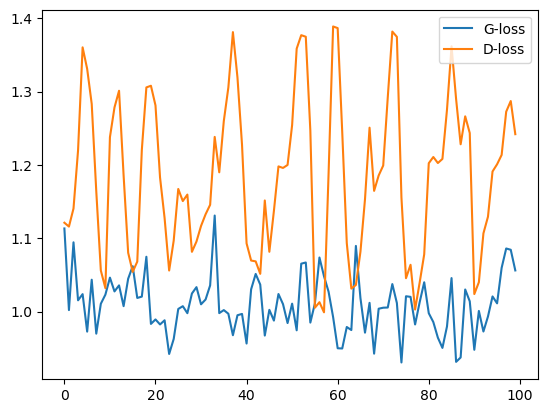

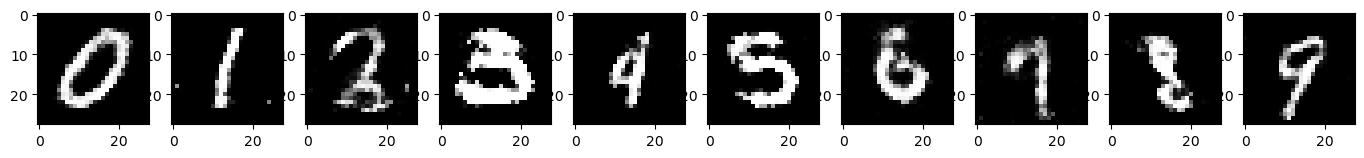

G_loss: 1.002466497540474 D_loss: 1.1825262172619502


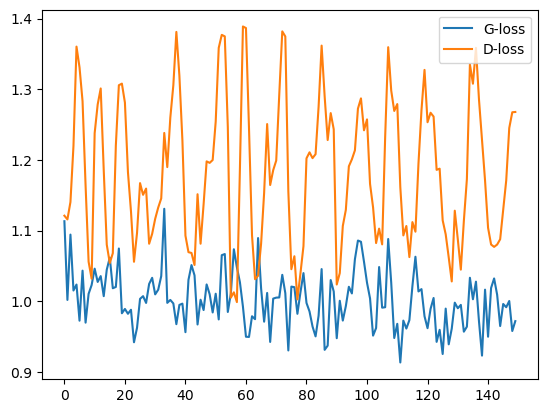

G_loss: 1.0013984064737955 D_loss: 1.1823746531804402


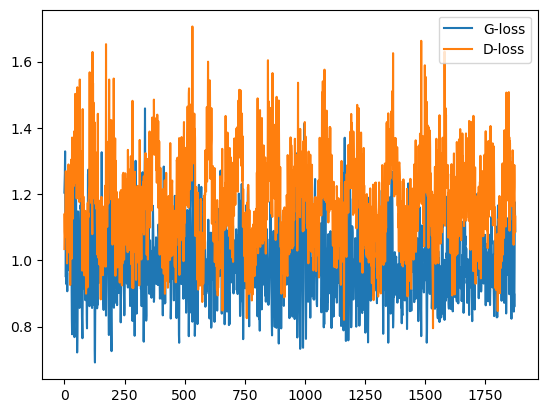

([2.279520630200704,
  1.8905435106595356,
  2.721614188702901,
  2.9284408940633138,
  2.3466173504511514,
  2.2943557233810425,
  2.2989925275802614,
  2.06375799109141,
  1.894506342156728,
  1.8045601794242858,
  1.8241700593312582,
  1.7279750528971354,
  1.5699119216283162,
  1.5343134140650432,
  1.4093738119443258,
  1.4112341053962707,
  1.3995843612670897,
  1.3280149344762167,
  1.2730474066416422,
  1.2481783474604289,
  1.2403852093060812,
  1.2173603063583374,
  1.146848431523641,
  1.1677618195851645,
  1.1352914730072021,
  1.1335820362091065,
  1.116870445760091,
  1.1087978452364604,
  1.0876395292599996,
  1.095497126897176,
  1.0956182857831318,
  1.0762957195281981,
  1.0653392244021098,
  1.0562770878156027,
  1.0580163425445557,
  1.0500776587486267,
  1.0608150510470074,
  1.031662497997284,
  1.0377107636769614,
  1.0395404337882996,
  1.0368742524147034,
  1.0167204166094461,
  1.0329481910387674,
  1.0217249478975932,
  1.032082661628723,
  1.014558025487264,

In [11]:
model = GAN(device)
model.train_(trainloader, EPOCHS)

In [12]:
model.eval()

GAN(
  (G): G_model(
    (embed): Embedding(10, 10)
    (model): Sequential(
      (0): Linear(in_features=110, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=784, bias=True)
      (5): Tanh()
    )
  )
  (D): D_model(
    (embed): Embedding(10, 10)
    (model): Sequential(
      (0): Linear(in_features=794, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=256, out_features=784, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=784, out_features=1, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
  )
)

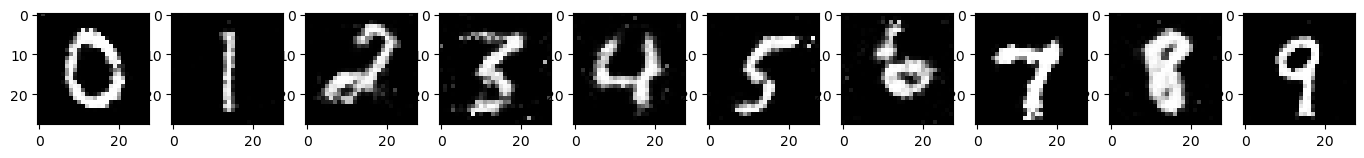

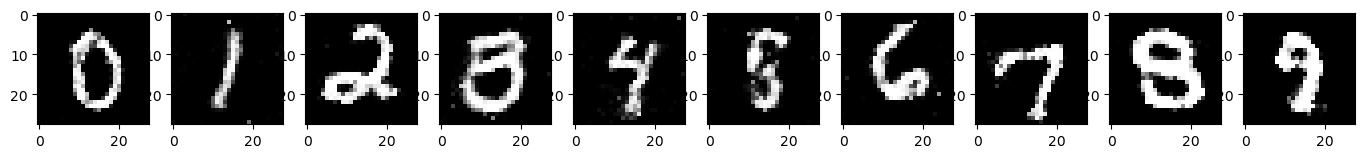

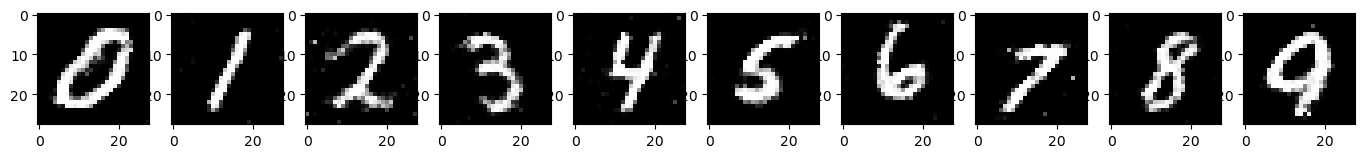

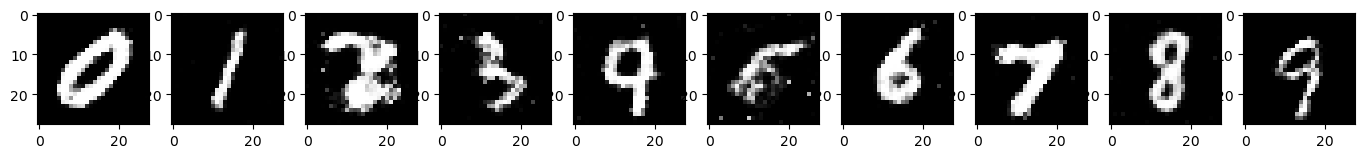

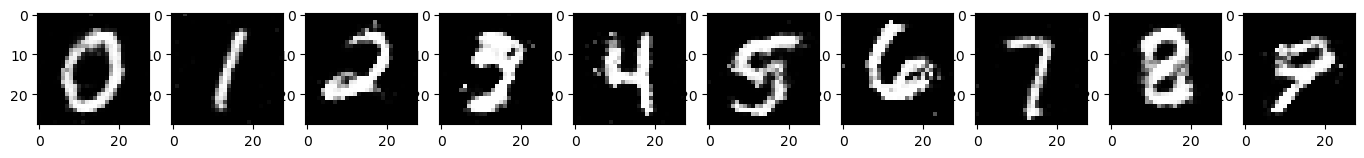

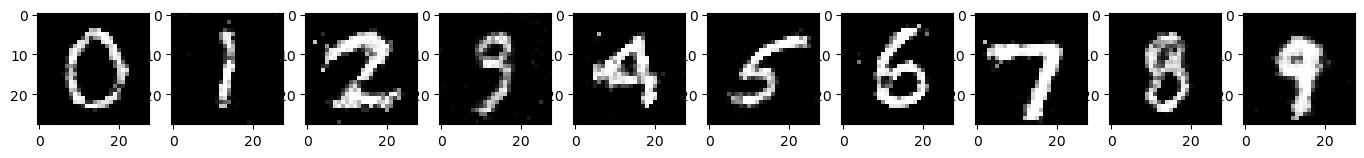

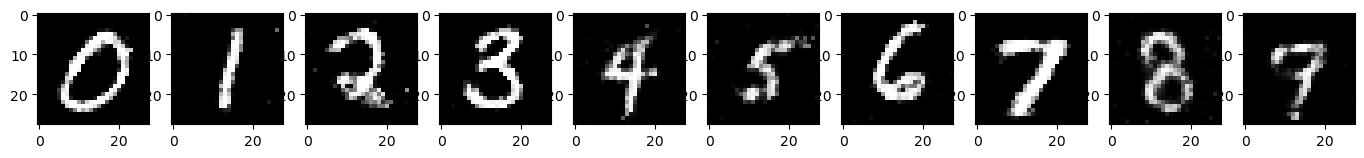

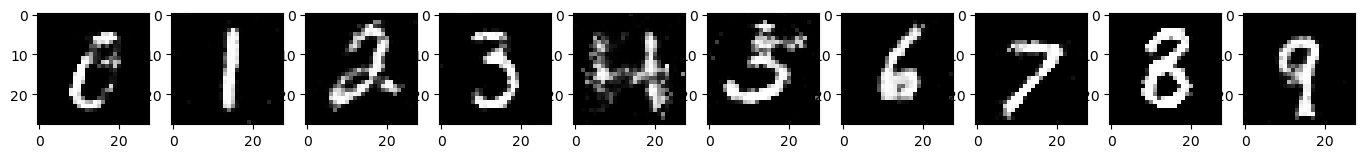

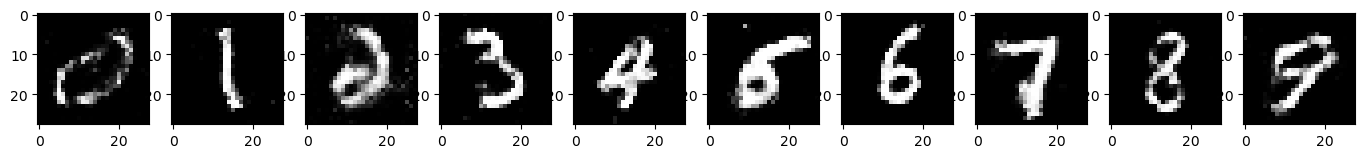

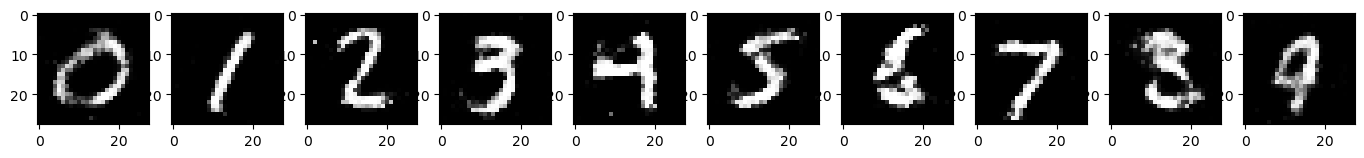

In [13]:
for evan in range(10):
    _, axs = plt.subplots(1, 10, figsize=(17, 6))

    # imgs = self.G(noise_fixed)
    imgs = model(10, torch.arange(10))
    for j, img in enumerate(imgs):
        axs[j].imshow(
            undo_transform(img.cpu().detach().view(1, 28, 28)).view(28, 28).numpy(), cmap="gray")

    plt.show()